# Annotation Reader

In [51]:
import re
from datetime import datetime

# Define the file path
file_path = '/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/annotations/annotations.txt'

# Function to safely parse coordinate data
def parse_coordinates(coord_string):
    try:
        coordinates = eval(coord_string)
        if isinstance(coordinates, list) and all(isinstance(coord, tuple) for coord in coordinates):
            return coordinates
    except:
        return []

# Function to parse a line
def parse_line(line):
    # Use regex to split line while ignoring commas within square brackets
    parts = re.split(r',(?![^\[\]]*\])', line.strip())

    if len(parts) < 6:
        return None, 'Insufficient data'

    try:
        active = int(parts[0])
        index = int(parts[1])
        data_type = int(parts[2])
        coordinates = parse_coordinates(parts[3])
        colour = parts[4]
        fixed_value = int(parts[5])
    except ValueError as e:
        return None, str(e)

    return {
        'Active': active,
        'Index': index,
        'Type': data_type,
        'Coordinates': coordinates,
        'Colour': colour,
        'Fixed Value': fixed_value
    }, None

# Main function to read and categorize data
def read_and_categorize(file_path):
    categorized_data = []
    error_count = 0

    try:
        with open(file_path, 'r') as file:
            for line in file:
                parsed_data, error = parse_line(line)
                if parsed_data:
                    categorized_data.append(parsed_data)
#                     print("Data parsed successfully:", parsed_data)
                elif error:
                    print(f"Skipping line due to parsing error: {line}. Error: {error}")
                    error_count += 1
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

    return categorized_data, error_count

# Read and print the categorized data
categorized_data, error_count = read_and_categorize(file_path)

if not categorized_data and error_count == 0:
    print("No data was parsed successfully.")
else:
    print(f"Total number of parsing errors: {error_count}")


Skipping line due to parsing error: 1,17,6,[(0.6341298530744202,0.9107860149071415),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
. Error: invalid literal for int() with base 10: ''
Skipping line due to parsing error: 1,1988,6,[(0.6342029618406476,0.9109958133994494),
. Error: invalid literal for int() with base 10: ''
Skipping line due to parsing error: (0.6503451583942874,0.8844702322448736)],#00ffff,1,20/11/2023/14:44:48                      

In [52]:
points_normalized = []
for i in range(len(categorized_data)):
    points_normalized.append(categorized_data[i]['Coordinates'][0])

    
max(points_normalized, key=lambda x:x[0])


(0.7315173798122041, 0.8382083871183299)

In [61]:
sum = 0
for i in range(len(categorized_data)):
    if categorized_data[i]['Colour'] == '#00ffff':
        sum += 1
print(sum)

2109


all points: 3520
 points shows: 3520


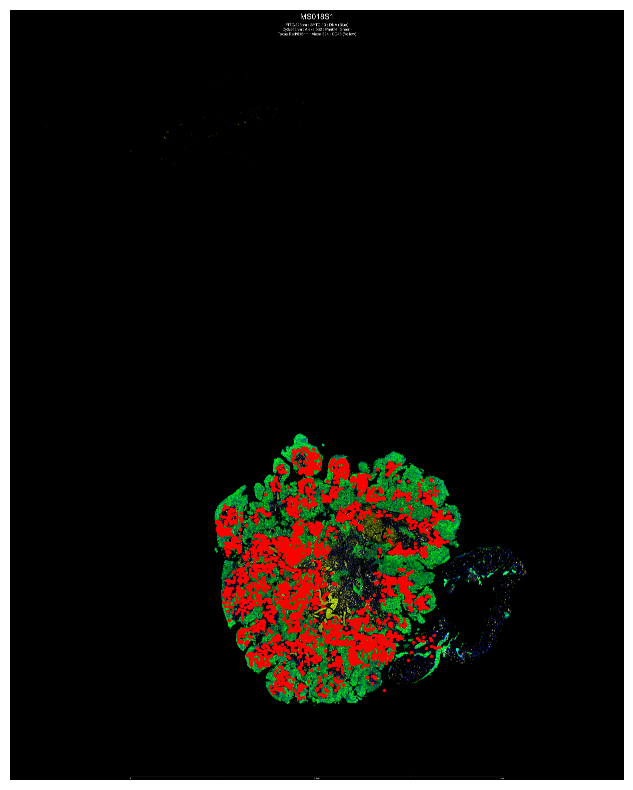

In [4]:
import cv2
import matplotlib.pyplot as plt

# Path to your image
image_path = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/MS018S1.png"

# Load the image using OpenCV
image = cv2.imread(image_path)

# Get the width and height of the image
height, width, _ = image.shape
# List of normalized points (x, y)
points_normalized = []

for i in range(len(categorized_data)):
    points_normalized.append(categorized_data[i]['Coordinates'][0])


    # Convert normalized coordinates to pixel values
points_pixel = [(int(x * width), int(y * width)) for x, y in points_normalized]

plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

print(f'all points: {len(points_pixel)}')
points_show = 0
# Plot the points on the image
for x, y in points_pixel:
    plt.scatter(x, y, c='red', marker='o', s=2)
    points_show += 1
      
print(f' points shows: {points_show}')

plt.axis("off")
plt.savefig("/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/annotations/MS018S1.png")    
# Show the image with points
plt.show()

# ROI detection

ROI at (10564, 20859): Width = 1649, Height = 1964
ROI at (8236, 19879): Width = 1656, Height = 1964
ROI at (10897, 18055): Width = 1659, Height = 1972
ROI at (7489, 16535): Width = 1652, Height = 1978
ROI at (12771, 16270): Width = 1660, Height = 1971
ROI at (10077, 15770): Width = 1671, Height = 1971


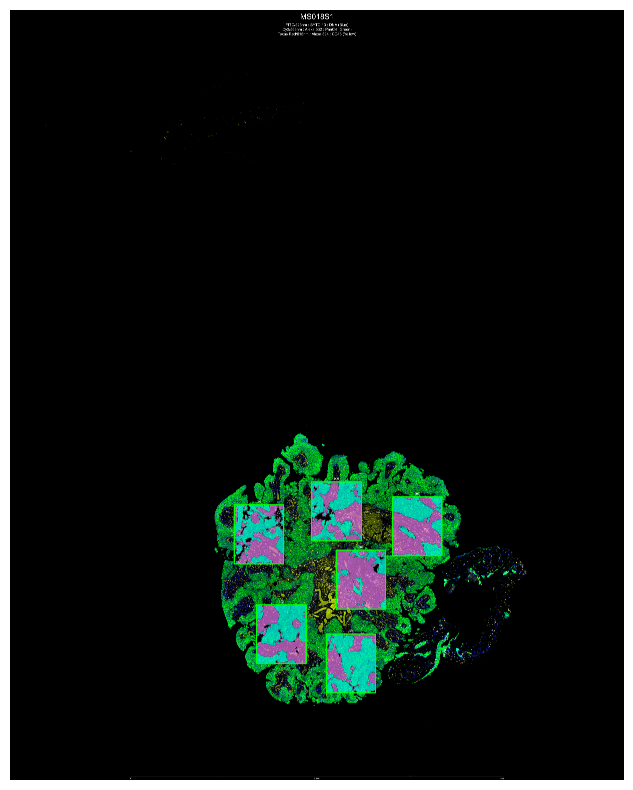

[(10564, 20859, 12213, 22823), (8236, 19879, 9892, 21843), (10897, 18055, 12556, 20027), (7489, 16535, 9141, 18513), (12771, 16270, 14431, 18241), (10077, 15770, 11748, 17741)]


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


image_number = 18
SET = 2
image_name = f'MS0{image_number}S1'

def detect_rois_and_crop_from_another_image(first_image_path, second_image_path, output_folder, min_width=300, min_height=300, lower_white=np.array([100,100,100]), upper_white=np.array([255,255,255])):
    # Read the first image
    image = cv2.imread(first_image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for white color
    mask = cv2.inRange(image, lower_white, upper_white)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Load the second image for cropping
    crop_image = cv2.imread(second_image_path)

    roi_boxes = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Check for minimum size
        if w >= min_width and h >= min_height:
            epsilon = 0.05 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the contour is rectangular (has 4 vertices)
            if len(approx) == 4:
                roi_boxes.append((x, y, x+w, y+h))
                # Draw a bounding box around the detected ROI on the first image
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 40)

                # Crop the ROI from the second image using the same coordinates
                roi = crop_image[y:y+h, x:x+w]
                # Save the cropped ROI
                cv2.imwrite(os.path.join(output_folder, f"{image_number}_roi_{i}.jpg"), roi)
                print(f"ROI at ({x}, {y}): Width = {w}, Height = {h}")
                
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the result using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    return roi_boxes

# Example usage
first_image_path = f"/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET{SET}/{image_name}_MU.png"
second_image_path = f"/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET{SET}/{image_name}.png"
output_folder = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/ROIs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

rois = detect_rois_and_crop_from_another_image(first_image_path, second_image_path, output_folder)
print(rois)


# Modified ROI to be same Size

ROI at (10564, 20859): Common Width = 1649, Common Height = 1964
ROI at (8239, 19879): Common Width = 1649, Common Height = 1964
ROI at (10902, 18059): Common Width = 1649, Common Height = 1964
ROI at (7490, 16542): Common Width = 1649, Common Height = 1964
ROI at (12776, 16273): Common Width = 1649, Common Height = 1964
ROI at (10088, 15773): Common Width = 1649, Common Height = 1964


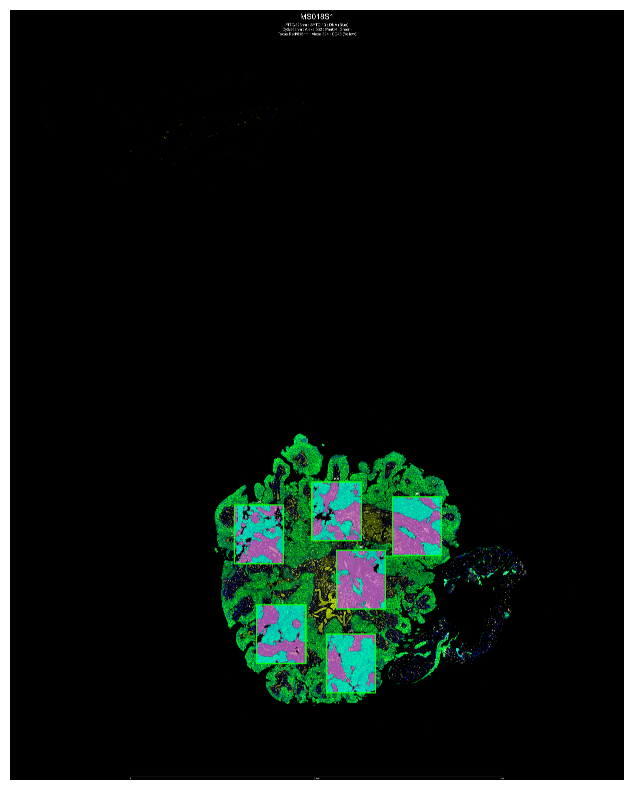

[(10564, 20859, 12213, 22823), (8239, 19879, 9888, 21843), (10902, 18059, 12551, 20023), (7490, 16542, 9139, 18506), (12776, 16273, 14425, 18237), (10088, 15773, 11737, 17737)]


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


image_number = 18
SET = 2
image_name = f'MS0{image_number}S1'

def detect_rois_and_crop_from_another_image(first_image_path, second_image_path, output_folder, min_width=300, min_height=300, lower_white=np.array([100,100,100]), upper_white=np.array([255,255,255])):
    # Read the first image
    image = cv2.imread(first_image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for white color
    mask = cv2.inRange(image, lower_white, upper_white)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Load the second image for cropping
    crop_image = cv2.imread(second_image_path)

    # Initialize lists to store width and height of each ROI
    widths = []
    heights = []

    # First iteration to find minimum width and height
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w >= min_width and h >= min_height:
            widths.append(w)
            heights.append(h)

    # Determine common width and height for all ROIs
    common_width = min(widths)
    common_height = min(heights)

    roi_boxes = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Check for minimum size
        if w >= min_width and h >= min_height:
            epsilon = 0.05 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Adjust x, y, width, and height to get the common size ROI
            new_x = max(x + (w - common_width) // 2, 0)
            new_y = max(y + (h - common_height) // 2, 0)
            roi_boxes.append((new_x, new_y, new_x + common_width, new_y + common_height))

            # Draw a bounding box around the detected ROI on the first image
            cv2.rectangle(image, (new_x, new_y), (new_x + common_width, new_y + common_height), (0, 255, 0), 40)

            # Crop the ROI from the second image using the adjusted coordinates
            roi = crop_image[new_y:new_y + common_height, new_x:new_x + common_width]
            cv2.imwrite(os.path.join(output_folder, f"{image_number}_roi_{i}.jpg"), roi)
            print(f"ROI at ({new_x}, {new_y}): Common Width = {common_width}, Common Height = {common_height}")

    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the result using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    return roi_boxes


# Example usage
first_image_path = f"/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET{SET}/{image_name}_MU.png"
second_image_path = f"/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET{SET}/{image_name}.png"
output_folder = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/ROIs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

rois = detect_rois_and_crop_from_another_image(first_image_path, second_image_path, output_folder)
print(rois)


In [62]:
rois

[(10564, 20859, 12213, 22823),
 (8239, 19879, 9888, 21843),
 (10902, 18059, 12551, 20023),
 (7490, 16542, 9139, 18506),
 (12776, 16273, 14425, 18237),
 (10088, 15773, 11737, 17737)]

# Annotaions inside ROIs

Image dimensions: 20516 x 25739
Points_pixel: 3520
Points_pixel: 3520
Sample points (in pixel coordinates): [(10187, 19509), (10254, 19515)]
ROI: (10564, 20859, 12213, 22823)
ROI: (8239, 19879, 9888, 21843)
ROI: (10902, 18059, 12551, 20023)
ROI: (7490, 16542, 9139, 18506)
ROI: (12776, 16273, 14425, 18237)
ROI: (10088, 15773, 11737, 17737)


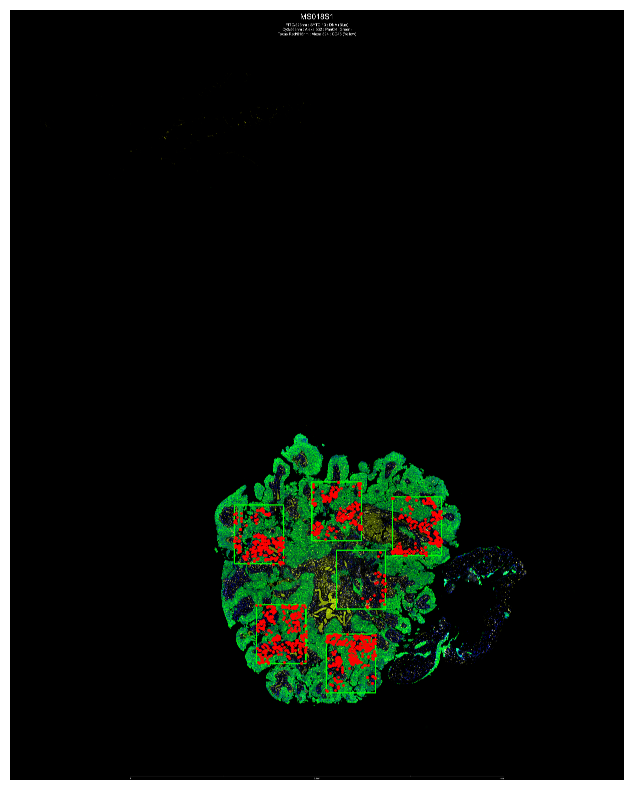

1222


In [23]:
import cv2
import matplotlib.pyplot as plt

def is_point_in_roi(point, roi):
    x, y = point
    roi_x1, roi_y1, roi_x2, roi_y2 = roi
    return roi_x1 <= x <= roi_x2 and roi_y1 <= y <= roi_y2

image_path = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/MS018S1.png"
image = cv2.imread(image_path)
height, width, _ = image.shape

print("Image dimensions:", width, "x", height)
print("Points_pixel:", len(points_pixel))


points_pixel = [(int(x * width), int(y * width)) for x, y in points_normalized]

print("Points_pixel:", len(points_pixel))


# Print some sample point coordinates for verification
print("Sample points (in pixel coordinates):", points_pixel[:2])

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw each ROI on the image
for roi in rois:
    x1, y1, x2, y2 = roi
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 40)

    # Print ROI coordinates for verification
    print("ROI:", roi)

# Set figure size
plt.figure(figsize=(10, 10))


total_points = 0


# Plot only the points that are inside any of the ROIs
for point in points_pixel:
    if any(is_point_in_roi(point, roi) for roi in rois):
        plt.scatter(point[0], point[1], c='red', marker='o', s=1)
        total_points += 1

# Display the image
plt.imshow(image_rgb)
plt.axis("off")
plt.show()
print(total_points)

Total points inside ROIs: 1237
Total points: 3520


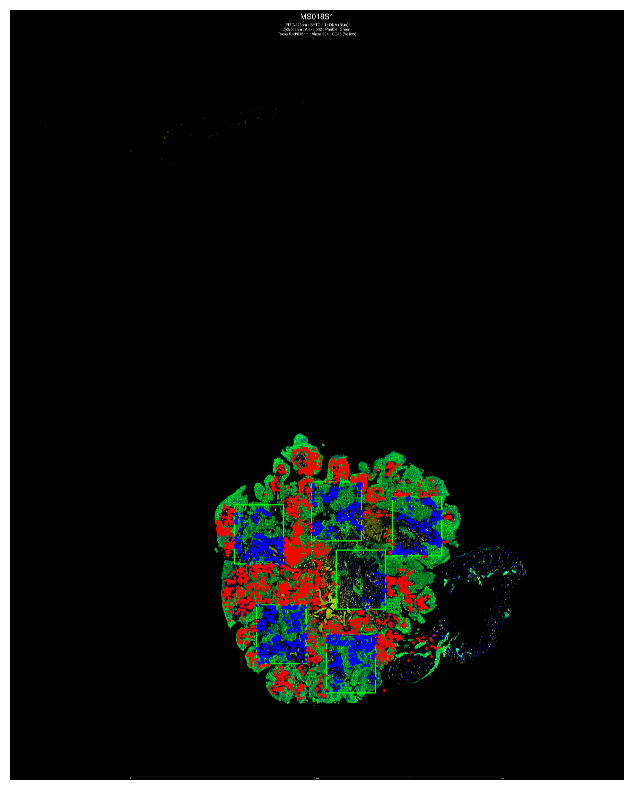

In [7]:
import cv2
import matplotlib.pyplot as plt

total_points = 0

# Draw each ROI on the image
for roi in rois:
    x1, y1, x2, y2 = roi
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Set figure size
plt.figure(figsize=(10, 10))
    
# Plot and count the points that are inside any of the ROIs
for point in points_pixel:
    if any(is_point_in_roi(point, roi) for roi in rois):
        plt.scatter(point[0], point[1], c='blue', marker='o', s=1)  # Points inside ROI
        total_points += 1
    else:
        plt.scatter(point[0], point[1], c='red', marker='o', s=1)  # Points outside ROI

print("Total points inside ROIs:", total_points)
print("Total points:", len(points_pixel))



# Display the image
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


# Save Cooardinate of points Locally and globally

In [30]:
import csv

def is_point_in_roi(point, roi):
    x, y = point
    roi_x1, roi_y1, roi_x2, roi_y2 = roi
    return roi_x1 <= x <= roi_x2 and roi_y1 <= y <= roi_y2

# Dictionary to hold points for each ROI
roi_points = {roi_index: [] for roi_index, _ in enumerate(rois)}

# Populate the dictionary with points
for point in points_pixel:
    for roi_index, roi in enumerate(rois):
        if is_point_in_roi(point, roi):
            # Calculate local coordinates (relative to top-left of ROI)
            local_x = point[0] - roi[0]  # roi[0] is roi_x1
            local_y = point[1] - roi[1]  # roi[1] is roi_y1
            roi_points[roi_index].append((point, (local_x, local_y)))
            break

# Write points to separate CSV files
for roi_index, points in roi_points.items():
    with open(f'/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/annotations/roi_{roi_index+1}_points.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Global X', 'Global Y', 'Local X', 'Local Y'])  # Header
        for global_point, local_point in points:
            writer.writerow([global_point[0], global_point[1], local_point[0], local_point[1]])

    print(f'ROI {roi_index+1}: {len(points)} points written to roi_{roi_index+1}_points.csv')


ROI 1: 266 points written to roi_1_points.csv
ROI 2: 282 points written to roi_2_points.csv
ROI 3: 31 points written to roi_3_points.csv
ROI 4: 241 points written to roi_4_points.csv
ROI 5: 215 points written to roi_5_points.csv
ROI 6: 187 points written to roi_6_points.csv


In [31]:
rois

[(10564, 20859, 12213, 22823),
 (8239, 19879, 9888, 21843),
 (10902, 18059, 12551, 20023),
 (7490, 16542, 9139, 18506),
 (12776, 16273, 14425, 18237),
 (10088, 15773, 11737, 17737)]

In [42]:
import csv

def is_point_in_roi(point, roi):
    x, y = point
    roi_x1, roi_y1, roi_x2, roi_y2 = roi
    return roi_x1 <= x <= roi_x2 and roi_y1 <= y <= roi_y2

# Create a dictionary to map ROI indices to ROI names
roi_names = {
    0: "1",
    1: "2",
    2: "3",
    3: "4",
    4: "5",
    5: "6"
    # Add more ROI names as needed
}

# Dictionary to hold points for each ROI
roi_points = {roi_index: [] for roi_index, _ in enumerate(rois)}

# Populate the dictionary with points
for point in points_pixel:
    for roi_index, roi in enumerate(rois):
        is_inside = is_point_in_roi(point, roi)
        if is_inside:
            # Calculate local coordinates (relative to top-left of ROI)
            local_x = point[0] - roi[0]  # roi[0] is roi_x1
            local_y = point[1] - roi[1]  # roi[1] is roi_y1
            roi_points[roi_index].append((point, (local_x, local_y)))

# Write points to separate CSV files
for roi_index, points in roi_points.items():
    with open(f'/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/annotations/Annotations/roi_{roi_index+1}_points.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Global_X', 'Global_Y', 'Local_X', 'Local_Y', 'ROI_Name'])  # Header
        for global_point, local_point in points:
            roi_name = roi_names.get(roi_index, "Unknown")  # Get the ROI name or use "Unknown" if not found
            writer.writerow([global_point[0], global_point[1], local_point[0], local_point[1], roi_name])

    print(f'ROI {roi_index+1}: {len(points)} points written to roi_{roi_index+1}_points.csv')


ROI 1: 266 points written to roi_1_points.csv
ROI 2: 282 points written to roi_2_points.csv
ROI 3: 31 points written to roi_3_points.csv
ROI 4: 241 points written to roi_4_points.csv
ROI 5: 215 points written to roi_5_points.csv
ROI 6: 187 points written to roi_6_points.csv


# Show case on ROI

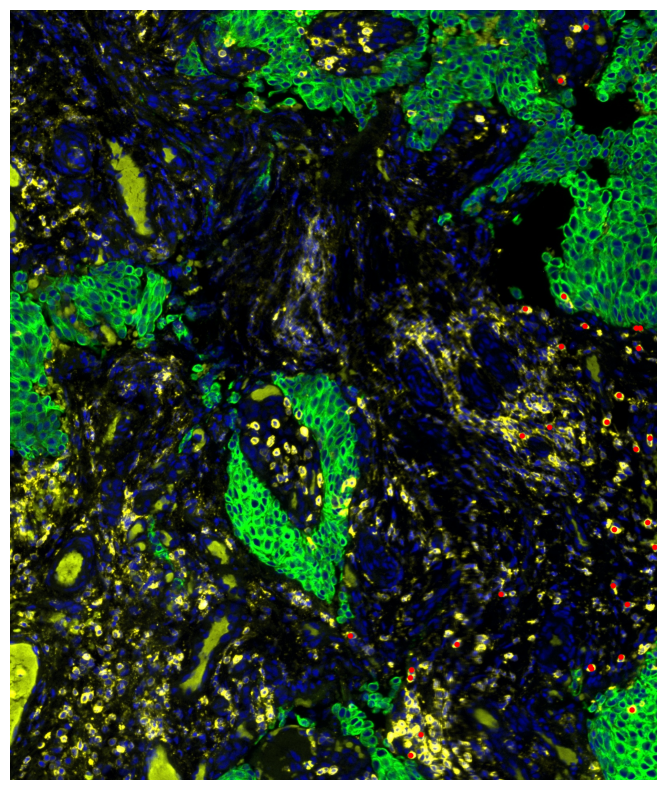

In [43]:
import cv2
import matplotlib.pyplot as plt
import csv

# Path to the ROI image and CSV file
image_path = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/annotations/ROIs/3.jpg"
csv_path = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/annotations/Annotations/roi_3_points.csv"

# Load the image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read points from the CSV file
points = []
with open(csv_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        local_x, local_y = int(row[2]), int(row[3])
        points.append((local_x, local_y))

# Plot the points on the image
for x, y in points:
    cv2.circle(image_rgb, (x, y), 7, (255, 0, 0), -1)  # Green points

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


In [50]:
import csv

# Define the bounding box offset
offset_x, offset_y = 25, 25  # Example offsets

def calculate_bounding_box(local_x, local_y, offset_x, offset_y):
    x1 = local_x - offset_x
    y1 = local_y - offset_y
    x2 = local_x + offset_x
    y2 = local_y + offset_y
    return x1, y1, x2, y2

def is_point_in_roi(point, roi):
    x, y = point
    roi_x1, roi_y1, roi_x2, roi_y2 = roi
    return roi_x1 <= x <= roi_x2 and roi_y1 <= y <= roi_y2

# Create a dictionary to map ROI indices to ROI names
roi_names = {
    0: "1",
    1: "2",
    2: "3",
    3: "4",
    4: "5",
    5: "6"
    # Add more ROI names as needed
}

# Dictionary to hold points for each ROI
roi_points = {roi_index: [] for roi_index, _ in enumerate(rois)}

# Populate the dictionary with points
for point in points_pixel:
    for roi_index, roi in enumerate(rois):
        is_inside = is_point_in_roi(point, roi)
        if is_inside:
            # Calculate local coordinates (relative to top-left of ROI)
            local_x = point[0] - roi[0]  # roi[0] is roi_x1
            local_y = point[1] - roi[1]  # roi[1] is roi_y1
            roi_points[roi_index].append((point, (local_x, local_y)))

# Write points and bounding boxes to separate CSV files
for roi_index, points in roi_points.items():
    with open(f'/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/annotations/Annotations/roi_{roi_index+1}_points.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Global_X', 'Global_Y', 'Local_X', 'Local_Y', 'ROI_Name', 'BB_X1', 'BB_Y1', 'BB_X2', 'BB_Y2'])  # Updated Header
        for global_point, local_point in points:
            roi_name = roi_names.get(roi_index, "Unknown")
            bb_x1, bb_y1, bb_x2, bb_y2 = calculate_bounding_box(local_point[0], local_point[1], offset_x, offset_y)
            writer.writerow([global_point[0], global_point[1], local_point[0], local_point[1], roi_name, bb_x1, bb_y1, bb_x2, bb_y2])

    print(f'ROI {roi_index+1}: {len(points)} points with bounding boxes written to roi_{roi_index+1}_points.csv')


ROI 1: 266 points with bounding boxes written to roi_1_points.csv
ROI 2: 282 points with bounding boxes written to roi_2_points.csv
ROI 3: 31 points with bounding boxes written to roi_3_points.csv
ROI 4: 241 points with bounding boxes written to roi_4_points.csv
ROI 5: 215 points with bounding boxes written to roi_5_points.csv
ROI 6: 187 points with bounding boxes written to roi_6_points.csv


# Yolo Requierment